## Mode Share Predictions - PSRC Travel Survey 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from seaborn.linearmodels import corrplot,symmatplot

#from sklearn.linear_model import LogisticRegression
#from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import log_loss
#from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

from datetime import datetime

#https://jmetzen.github.io/2015-01-29/ml_advice.html

/Users/xx/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the data sets
data_dir = './data/'
df_Trip_Household_Merged = pd.read_csv(data_dir + 'Trip_Household_Merged.csv')

print (df_Trip_Household_Merged)
#print(df_Trip_Household_Merged.dtypes)

             tripid      hhid  origin_lat  origin_lng    dest_lat    dest_lng  \
0      1.710000e+12  17119958   47.707597 -122.118828  999.000000  999.000000   
1      1.710000e+12  17119958   47.707597 -122.118828  999.000000  999.000000   
2      1.710000e+12  17119958   47.707597 -122.118828  999.000000  999.000000   
3      1.710000e+12  17108513   34.857550  132.033550   31.687940  124.343310   
4      1.710000e+12  17108513   31.150120  121.798040   31.316290  120.660290   
5      1.710000e+12  17108513   31.316290  120.660290   31.325580  120.517380   
6      1.710000e+12  17132862   39.983014  116.460013   39.986479  116.460180   
7      1.710000e+12  17132862   39.973713  116.276579   39.986479  116.460180   
8      1.710000e+12  17132862   39.986479  116.460180   39.983014  116.460013   
9      1.710000e+12  17132862   39.986479  116.460180   39.973713  116.276579   
10     1.710000e+12  17116598   47.438490 -122.298390   22.315980  114.161110   
11     1.710000e+12  1710484

/Users/xx/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pre-processing

In [4]:
df_Trip_Household_Merged = pd.read_csv(data_dir + 'Trip_Household_Merged.csv')


# Filter trips that end outside seattle
df_Trip_Household_Merged = df_Trip_Household_Merged[df_Trip_Household_Merged['uv_dest'] != "Outside Seattle"]

# drop data that are not in urban villages
df_Trip_Household_Merged = df_Trip_Household_Merged[(df_Trip_Household_Merged['uv_origin'] != "Outside Seattle") &
                                                    (df_Trip_Household_Merged['uv_origin'] != "Outside Villages")]

# Create dummy variables for departure time period
depart_period_dummies = pd.get_dummies(df_Trip_Household_Merged['depart_period'])

df_Trip_Household_Merged['weekday_am'] = depart_period_dummies['Weekday AM']
df_Trip_Household_Merged['weekday_mid'] = depart_period_dummies['Weekday Mid']
df_Trip_Household_Merged['weekday_pm'] = depart_period_dummies['Weekday PM']
df_Trip_Household_Merged['weekday_late'] = depart_period_dummies['Late Night']

# Create dummie variables for residency duration, with justs two categories, under and over 5 years (see codebook)
df_Trip_Household_Merged['residency_under5'] = np.where((df_Trip_Household_Merged['res_dur']<=3), 1, 0)
df_Trip_Household_Merged['residency_over5'] = np.where((df_Trip_Household_Merged['res_dur']>3), 1, 0)

# Create dummie variables for home ownership
df_Trip_Household_Merged['hh_rent'] = np.where((df_Trip_Household_Merged['rent_own']==2), 1, 0)
df_Trip_Household_Merged['hh_own'] = np.where((df_Trip_Household_Merged['rent_own']==1), 1, 0)

# Create dummie variables for income
df_Trip_Household_Merged['income_under25'] = np.where((df_Trip_Household_Merged['hhincome_broad']==1), 1, 0)
df_Trip_Household_Merged['income_25_50'] = np.where((df_Trip_Household_Merged['hhincome_broad']==2), 1, 0)
df_Trip_Household_Merged['income_50_75'] = np.where((df_Trip_Household_Merged['hhincome_broad']==3), 1, 0)
df_Trip_Household_Merged['income_75_100'] = np.where((df_Trip_Household_Merged['hhincome_broad']==4), 1, 0)
df_Trip_Household_Merged['income_over100'] = np.where((df_Trip_Household_Merged['hhincome_broad']==5), 1, 0)

##aggregate by geography of origin

geography = ['uv_origin']
#geography = ['hhid']


trainFeatures = ['google_duration', 'trip_path_distance', 'hhsize', 'hh_rent','hh_own',
            'depart_time','hhincome_broad', 'rent_own', 'numchildren', 'vehicle_count',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late','residency_under5','residency_over5',
                'income_under25', 'income_25_50', 'income_75_100','income_75_100','income_over100','drive_alone','pct_white']


aggDict = {}
for feature in trainFeatures:
    aggDict[feature]=[sum]

# Apply trip weights prior to aggregation
for feature in trainFeatures:
    df_Trip_Household_Merged[feature] = df_Trip_Household_Merged['trip_wt_final'] * df_Trip_Household_Merged[feature]

aggDict['trip_wt_final'] =[sum]

data = df_Trip_Household_Merged.groupby(geography, as_index=False).agg(aggDict)
data.columns = data.columns.get_level_values(0)

# Reapply column weights to obtain averages for each location
for feature in trainFeatures:
   data[feature] = data[feature] / data['trip_wt_final']

# Create label for geographies under the citywide mean of 38%
data['drive_alone_threshold'] = np.where((data['drive_alone'] <= .40), 1, 0)

for feature in trainFeatures:
    data = data[data[feature].notnull()]
print (data)

# drop outlier
#data = data[data['drive_alone'] < .3]
#data = data[data['trip_wt_final'] > 1000]

#print(data.columns)
#print (data)

data.to_csv(data_dir + 'df_Trip_Processed_Agg_Village_Origin.csv', mode='w', header=True, index=False)


/Users/xx/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                           uv_origin  google_duration  trip_path_distance  \
0                        12th Avenue        13.783666            3.084662   
1               23rd & Union-Jackson         9.286290            2.065487   
2                            Admiral        10.715962            2.823961   
3              Aurora-Licton Springs        11.017323            3.361999   
4                            Ballard         8.104783            2.006286   
5          Ballard-Interbay-Northend         9.519243            2.350534   
6                           Belltown         9.690305            1.982422   
7                Bitter Lake Village        13.652500            4.678384   
8                       Capitol Hill        10.259373            1.890594   
9   Chinatown-International District        10.304163            2.373616   
10                     Columbia City        10.013304            2.549925   
11                   Commercial Core         5.124105            1.011690   

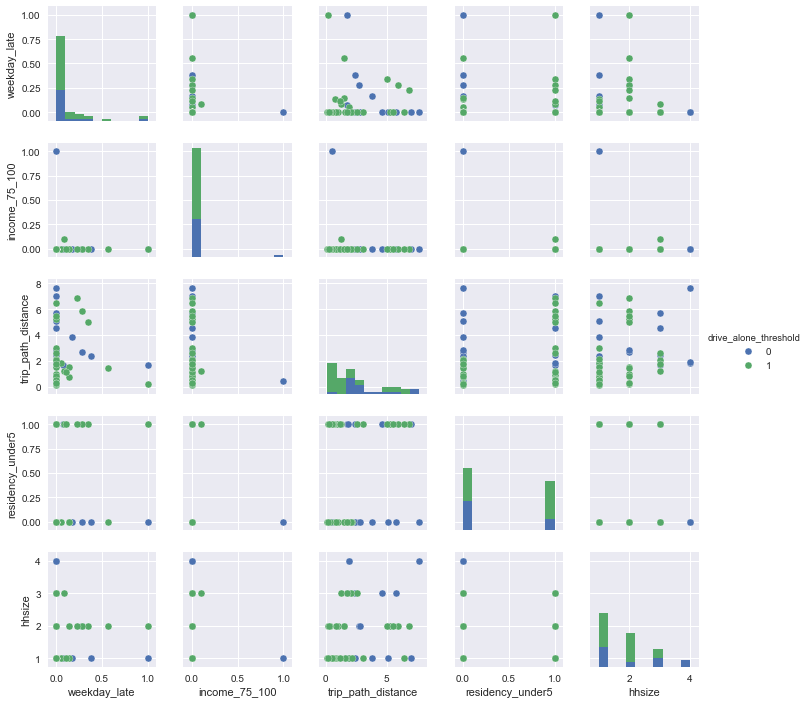

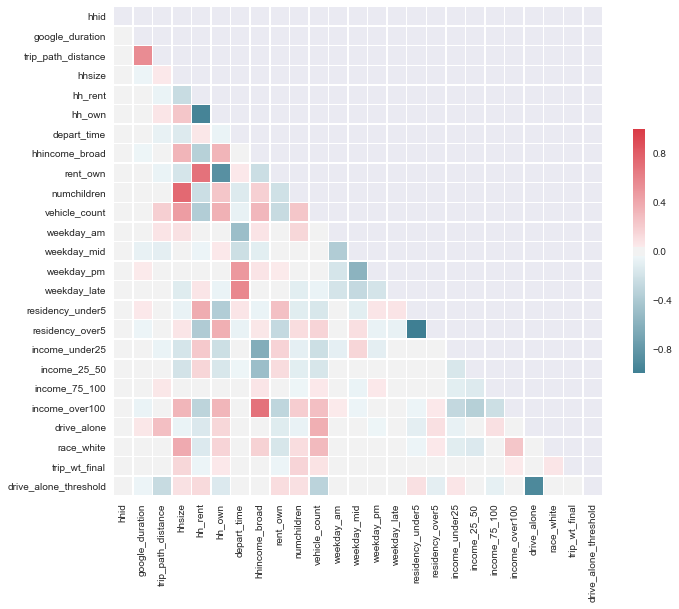

In [4]:
# Correlation charts to help identify features

_ = sns.pairplot(data[:50], vars=['weekday_late','income_75_100' , 'trip_path_distance', 
                                  'residency_under5', 'hhsize'], hue="drive_alone_threshold", size=2)

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear Regression - Machine Learning Pipeline

Multivariate cross validation with a linear regression model

[ 0.08616461] [[-0.00361359  0.0447068  -0.03037903  0.15650591 -0.09517386]]
Mean squared error: 0.112
Variance score: 0.195


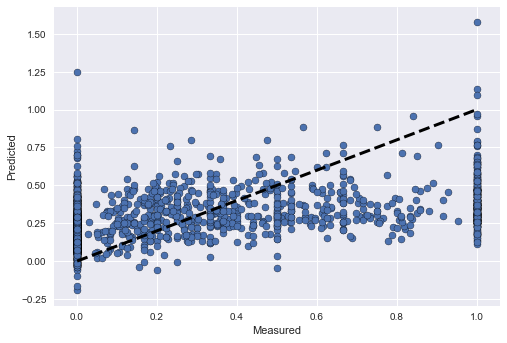

                    0  coefficient
0     google_duration    -0.003614
1  trip_path_distance     0.044707
2    residency_under5    -0.030379
3       vehicle_count     0.156506
4      income_over100    -0.095174
0.135098341626
0.203399336849
0.204175850063
0.200873721054
0.185268195748
mse: 0.124637461757  variance: 0.185268195748


(0.1127621321181473, 0.18576308906826189)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

Allfeatures = ['google_duration', 'trip_path_distance', 'hhsize', 'residency_under5',
            'numchildren', 'vehicle_count','hh_own',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late',
            'income_under25', 'income_25_50','income_75_100','income_over100']

features = ['google_duration', 'trip_path_distance', 'residency_under5','vehicle_count',
           'income_over100']


feature_list = features

target = ["drive_alone"]

def train_and_cross_val(cols, target):
    
   # Split into features & target.
    features = data[cols]
    target = data[target]

    variance_values = []
    mse_values = []
    
    # kFold instance
    kf = KFold(n=len(data), n_folds=5, shuffle=True, random_state = 3)
    
    # Iterate through each fold
    for train_index, test_index in kf:

        #Training and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Instantiate the model
        model = LinearRegression()
    
        # Fit model to features and target
        model.fit(X_train,y_train)
    
        # Make predictions
        predictions = model.predict(X_test)
    
        # Calulate mse and variance for this fold
        mse = mean_squared_error(y_test, predictions)
        variance = r2_score(y_test, predictions)
    
        # Append to arrays to do calculate overall 
        # average mse and variance values.
        variance_values.append(variance)
        mse_values.append(mse)
        print (variance)

    # Compute average mse and variance values.
    avg_mse = np.mean(mse_values)
    avg_var = np.mean(variance_values)
    
    print ("mse: " + str(mse)," variance: " + str(variance))
        
    return(avg_mse, avg_var)


def train_and_predict(cols, target):

    # Split into features & target.
    features = data[cols]
    target = data[target]

    # Instantiate the model
    model = LinearRegression()
    
    # fit the model
    model.fit(features,target)
    
    # Make predictions
    predictions = model.predict(features)
    mse = mean_squared_error(target, predictions)
    variance = r2_score(target, predictions)
    
    print (model.intercept_, model.coef_)

    # The mean squared error
    print("Mean squared error: %.3f"
      % mean_squared_error(target, predictions))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.3f' % r2_score(target, predictions))

    fig, ax = plt.subplots()
    ax.scatter(target, predictions, edgecolors=(0, 0, 0))
    ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    
    df_results = pd.DataFrame(feature_list)
    #df_results['feature'] = features
    df_results['coefficient'] = model.coef_[0]
    print (df_results)
    
train_and_predict(features, target)
train_and_cross_val(features, target)



# Test for Overfitting
At the heart of understanding overfitting is understanding bias and variance. Bias and variance make up the 2 observable sources of error in a model that we can indirectly control. Bias describes error that results in bad assumptions about the learning algorithm. Variance describes error that occurs because of the variability of a model's predicted values. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

For regression, we can use mean absolute error, mean squared error, or R-squared.

We can notice that there is a large gap between error on training and on validation data. What does that mean? We are probably overfitting the training data!


## Classification - Machine Learning Pipeline - SVC Linear Model

/Users/xx/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [12] are constant.
  UserWarning)
/Users/xx/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


trip_path_distance
residency_under5
numchildren
vehicle_count
hh_own
drive_alone_threshold    0     1
pred                            
0                      151   104
1                      389  1230
precision: [ 0.59215686  0.75972823]
recall: [ 0.27962963  0.92203898]
fscore: [ 0.37987421  0.83305113]
support: [ 540 1334]


/Users/xx/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


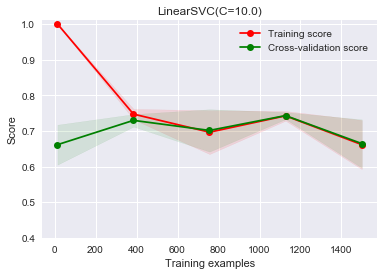

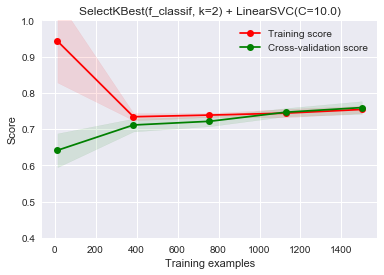

In [209]:
features = ['google_duration', 'trip_path_distance', 'hhsize', 'residency_under5',
            'numchildren', 'vehicle_count','hh_own',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late',
            'income_under25', 'income_25_50','income_75_100','income_over100']

feature_list = features

target = ["drive_alone_threshold"]

X = data[features]
y = data["drive_alone_threshold"]

# Model results with all features selected
from sklearn.svm import LinearSVC
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
                    X, y, ylim=(0.4, 1.01),
                    train_sizes=np.linspace(.01, 1, 5))

# Automatic feature selecion
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
# SelectKBest(f_classif, k=2) will select the k=2 best features according to their Anova F-value

plot_learning_curve(Pipeline([("fs", SelectKBest(f_classif, k=5)), # select two features
                               ("svc", LinearSVC(C=10.0))]),
                    "SelectKBest(f_classif, k=2) + LinearSVC(C=10.0)",
                    X, y, ylim=(0.4, 1.0),
                    train_sizes=np.linspace(.01, 1, 5))

# List the best features
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
# features_dataframe_new = data[idxs_selected]

bestFeatures = []

for index in selector.get_support(indices=True):
    bestFeatures.append(features[index])
    print (features[index])

# Train and predict model
train_and_predictCVS(bestFeatures, target)

In [189]:
# Modified from http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [187]:
def train_and_predictCVS(cols, target):

    # Split into features & target.
    features = data[cols]
    target = data[target]

    # Instantiate the model
    model = LinearSVC(C = 10.0, random_state = 3)
        
    # fit the model
    model.fit(features,target)
    
    # Make predictions
    predictions = model.predict(data[cols])
    mse = mean_squared_error(target, predictions)
    variance = r2_score(target, predictions)
    
    data['pred'] = model.predict(data[cols])
    
    # Crosstabs
    print(pd.crosstab(data['pred'], data['drive_alone_threshold']))
    
    
    # Scoring https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
    precision, recall, fscore, support = score(data['drive_alone_threshold'], predictions)

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    